In [1]:
import os
os.chdir('..')

import json
import uuid

from uuid import UUID
from datetime import date, datetime
from dateutil.tz import tzlocal
import numpy as np
from time import time
import re

In [2]:
import pynwb
from pynwb import NWBFile, NWBHDF5IO

In [3]:
import datajoint as dj

In [4]:
dj.list_schemas()

Connecting thinh@mesoscale-activity.datajoint.io:3306


['daveliu_ingestBehavior',
 'daveliu_ingestEphys',
 'map_ccf',
 'map_ephys',
 'map_experiment',
 'map_lab',
 'map_publication']

In [5]:
help(dj.create_virtual_module)

Help on function create_virtual_module in module datajoint.schema:

create_virtual_module(module_name, schema_name, create_schema=False, create_tables=False, connection=None)
    Creates a python module with the given name from the name of a schema on the server and
    automatically adds classes to it corresponding to the tables in the schema.
    
    :param module_name: displayed module name
    :param schema_name: name of the database in mysql
    :param create_schema: if True, create the schema on the database server
    :param create_tables: if True, module.schema can be used as the decorator for declaring new
    :return: the python module containing classes from the schema object and the table classes



In [6]:
lab = dj.create_virtual_module('lab', 'map_lab')
ephys = dj.create_virtual_module('ephys', 'map_ephys')
experiment = dj.create_virtual_module('experiment', 'map_experiment')
ccf = dj.create_virtual_module('ccf', 'map_ccf')

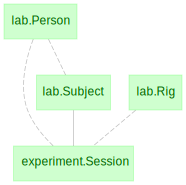

In [7]:
dj.ERD(experiment.Session) - 1

In [8]:
sessions =(experiment.Session & ephys.Unit).fetch('KEY')
session_key = sessions[3]
session_key

{'subject_id': 432998, 'session': 16}

## Session and Subject

In [9]:
session = (experiment.Session & session_key).fetch1()

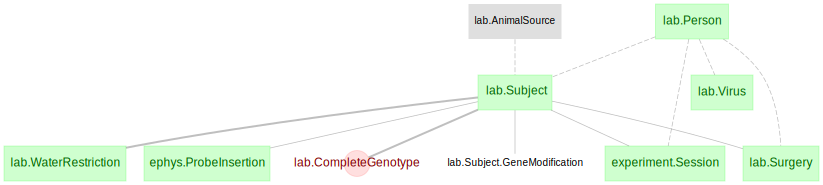

In [10]:
dj.ERD(lab.Subject) -1 + 1

In [11]:
subj = (lab.Subject * lab.CompleteGenotype & session_key).fetch1()

In [12]:
session

{'subject_id': 432998,
 'session': 16,
 'session_date': datetime.date(2019, 1, 13),
 'username': 'daveliu',
 'rig': 'RRig'}

In [13]:
subj

{'subject_id': 432998,
 'username': 'daveliu',
 'cage_number': 160920,
 'date_of_birth': datetime.date(2018, 7, 2),
 'sex': 'M',
 'animal_source': 'Jackson labs',
 'complete_genotype': 'VGAT-Chr2-EYFP Jax'}

In [14]:
# -- NWB file - a NWB2.0 file for each session
nwbfile = NWBFile(
    session_description='',
    identifier='_'.join(
        [str(session['subject_id']), str(session['session']),
         session['session_date'].strftime('%Y-%m-%d_%H-%M-%S')]),
    session_start_time=datetime.combine(session['session_date'], datetime.min.time()),
    file_create_date=datetime.now(tzlocal()),
    experimenter=session['username'],
    institution='Janelia Research Campus')

C:\ProgramData\Anaconda3\lib\site-packages\pynwb\file.py:615: UserWarning: Date is missing timezone information. Updating to local timezone.
  warn("Date is missing timezone information. Updating to local timezone.")


In [15]:
# -- subject
nwbfile.subject = pynwb.file.Subject(
    subject_id=str(subj['subject_id']),
    description=f'animal_source: {subj["animal_source"]}',
    genotype=subj['complete_genotype'],
    sex=subj['sex'])

## Units

### Electrode Group

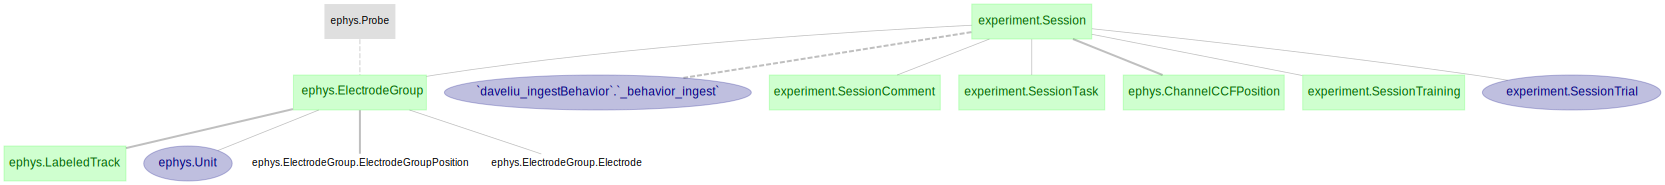

In [16]:
dj.ERD(ephys.ElectrodeGroup) - 1 + 1

In [17]:
probe = (ephys.ElectrodeGroup & session_key).fetch1()

In [18]:
probe

{'subject_id': 432998,
 'session': 16,
 'electrode_group': 1,
 'probe_part_no': '15131808323'}

In [19]:
device = nwbfile.create_device(name = probe['probe_part_no'])

In [20]:
electrode_group = nwbfile.create_electrode_group(
    name='',
    description = 'N/A',
    device = device,
    location = '')

In [23]:
for chn in (ephys.ElectrodeGroup.Electrode & probe).fetch(as_dict=True):
    nwbfile.add_electrode(id=chn['electrode'],
                          group=electrode_group,
                          filtering='Bandpass filtered 300-6K Hz',
                          imp=-1.,
                          location=electrode_group.location,
                          x=np.nan,
                          y=np.nan,
                          z=np.nan)

### Units

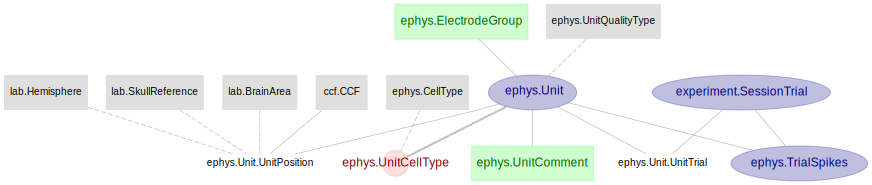

In [24]:
dj.ERD(ephys.Unit) + 1 - 1

In [25]:
units_view = ((ephys.Unit & session_key).aggr(
    ephys.UnitComment, *ephys.Unit.heading.names, comments='GROUP_CONCAT(unit_comment, "; ")', keep_all_rows=True).aggr(
    ephys.UnitCellType, "comments", *ephys.Unit.heading.names, cell_type='GROUP_CONCAT(cell_type, "; ")', keep_all_rows=True))

In [26]:
units_view

subject_id institution 6 digit animal ID,session session number,electrode_group Electrode_group is like the probe,unit,unit_uid unique across sessions/animals,unit_quality,unit_site site on the electrode for which the unit has the largest amplitude,unit_posx x position of the unit on the probe,unit_posy y position of the unit on the probe,spike_times (s),waveform average spike waveform,comments calculated attribute,cell_type calculated attribute
432998,16,1,0,0,good,3,5.8380560874938965,21.13640594482422,=BLOB=,=BLOB=,None,None
432998,16,1,1,1,good,4,30.044818878173828,13.278623580932617,=BLOB=,=BLOB=,None,None
432998,16,1,2,2,all,4,27.09010124206543,11.370380401611328,=BLOB=,=BLOB=,None,None
432998,16,1,3,3,good,6,43.52296447753906,45.51665496826172,=BLOB=,=BLOB=,None,None
432998,16,1,4,4,good,8,34.69549560546875,59.467247009277344,=BLOB=,=BLOB=,None,None
432998,16,1,5,5,all,9,15.389480590820312,79.84043884277344,=BLOB=,=BLOB=,None,None
432998,16,1,6,6,all,9,21.190349578857422,76.4383773803711,=BLOB=,=BLOB=,None,None


In [27]:
additional_unit_columns = [{'name': tag,
                  'description': re.sub('\s+:|\s+', ' ', re.search(
                      f'(?<={tag})(.*)', str(units_view.heading)).group())}
                for tag in units_view.heading.names
                if tag not in units_view.proj().heading.names + ['spike_times', 'waveform', 'electrode_group', 'electrode']]

In [28]:
additional_unit_columns

[{'name': 'unit_uid', 'description': '  int # unique across sessions/animals'},
 {'name': 'unit_quality', 'description': '  varchar(100) # '},
 {'name': 'unit_site',
  'description': '  smallint # site on the electrode for which the unit has the largest amplitude'},
 {'name': 'unit_posx',
  'description': '  double # x position of the unit on the probe'},
 {'name': 'unit_posy',
  'description': '  double # y position of the unit on the probe'},
 {'name': 'comments', 'description': '  expression # calculated attribute'},
 {'name': 'cell_type', 'description': '  expression # calculated attribute'}]

In [30]:
units_view.heading

subject_id           : int                          # institution 6 digit animal ID
session              : smallint                     # session number
electrode_group      : tinyint                      # Electrode_group is like the probe
unit                 : smallint                     # 
---
unit_uid             : int                          # unique across sessions/animals
unit_quality         : varchar(100)                 # 
unit_site            : smallint                     # site on the electrode for which the unit has the largest amplitude
unit_posx            : double                       # x position of the unit on the probe
unit_posy            : double                       # y position of the unit on the probe
spike_times          : longblob                     # (s)
waveform             : blob                         # average spike waveform
comments             : expression                   # calculated attribute
cell_type            : expression                

In [31]:
def select(d, *keys):
    return dict((k, v) for k, v in d.items() if k in keys)

In [32]:
for unit in units_view.fetch(as_dict=True):
    # make an electrode table region (which electrode(s) is this unit coming from)
    nwbfile.add_unit(id=unit['unit'],
                     electrode_group=electrode_group,
                     **unit,
                     waveform_mean=unit['waveform'])

TypeError: add_unit() got multiple values for keyword argument 'electrode_group'

In [ ]:
unit = units_view.fetch(as_dict=True)[0]

In [ ]:
unit['waveform'].shape